# Importing libraries

In [65]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)

cinic_directory_train = 'C:\\Users\\48695\\Documents\\Studia\\DLM\\Projekt CNN\\CINIC-10\\train' #'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\train'
cinic_directory_test = 'C:\\Users\\48695\\Documents\\Studia\\DLM\\Projekt CNN\\CINIC-10\\test' #'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\test'
cinic_directory_val = 'C:\\Users\\48695\\Documents\\Studia\\DLM\\Projekt CNN\\CINIC-10\\valid'

tf.random.set_seed(1337)

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax'
nb_epochs=50
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
metrics=['categorical_accuracy','AUC','Precision','Recall'] #można potem obliczyć F1 na podstawie recall i precision

# Helping functions

In [66]:
def show_training_validation_loss_and_metrics(model,metric):
    f,ax=plt.subplots(2,1,figsize=(10,10)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    ax[1].plot(model.history.history[metric],color='b',label='Training  Accuracy')
    ax[1].plot(model.history.history['val_'+metric],color='r',label='Validation '+metric)

    plt.legend() 

# Data loading

In [67]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [68]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [69]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [70]:
class_names= train_ds.class_names
num_classes = len(class_names)
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [71]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Inicjalizacja słownika do zliczania liczby obrazów w każdej klasie
#class_count = {class_name: 0 for class_name in class_names}

# Przechodzenie przez zbiór danych i zliczanie obrazów w każdej klasie
#for images, labels in train_ds:
#    for label in labels.numpy():
#        class_count[class_names[label]] += 1

# Wyświetlenie liczby obrazów w każdej klasie
#for class_name, count in class_count.items():
#    print(f"Liczba obrazów w klasie {class_name}: {count}")

# Dane do wykresu słupkowego
#class_names = list(class_count.keys())
#counts = list(class_count.values())

# Tworzenie wykresu słupkowego
#plt.figure(figsize=(10, 6))
#plt.bar(class_names, counts, color='skyblue')
#plt.xlabel('Klasa')
#plt.ylabel('Liczba obrazów')
#plt.title('Liczba obrazów w każdej klasie')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()

# Wyświetlenie wykresu
#plt.show()

# First model architecture

In [72]:
def create_Architecture1():
    model = Sequential([
        Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(32,32,3)),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Dropout(0.2),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Flatten(),
        Dense(units=512),
        Dropout(0.3),
        Dense(units=num_classes, activation="softmax")
    ])
    return model

In [16]:
model1 = create_Architecture1()

In [17]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [18]:
#model1.summary()

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
 693/5625 [==>...........................] - ETA: 5:07 - loss: 2.1210 - categorical_accuracy: 0.2836 - auc: 0.7540 - precision: 0.3634 - recall: 0.1328

KeyboardInterrupt: 

In [43]:
result=model1.evaluate(test_ds)

5625/5625 [==============================] - 109s 19ms/step - loss: 1.1249 - categorical_accuracy: 0.6438 - auc: 0.9335 - precision: 0.7105 - recall: 0.5898


In [73]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
tf_labels = tf.argmax(true_labels, axis=1).numpy()

In [35]:
predictions1 = model1.predict(test_ds)
predicted_classes1 = np.argmax(predictions1, axis=1)

5625/5625 [==============================] - 137s 24ms/step


In [16]:
conf_matrix1 = tf.math.confusion_matrix(tf_labels, predicted_classes1, num_classes=num_classes)

print("Confusion Matrix:")
print(conf_matrix1)

Confusion Matrix:
tf.Tensor(
[[1425  998  980  301  605  946 1202  806  791  946]
 [1336 1016 1009  302  600  964 1180  860  783  950]
 [1327 1004  962  332  657  992 1207  805  773  941]
 [1372 1002  953  304  629  965 1208  861  792  914]
 [1361  976 1025  297  649 1013 1159  817  812  891]
 [1369  950  956  298  636 1057 1165  827  809  933]
 [1402  984  985  286  583 1013 1203  811  819  914]
 [1361  991 1032  289  624 1006 1131  840  788  938]
 [1363  963  997  311  611  991 1189  839  809  927]
 [1446 1032  987  309  581  941 1158  753  828  965]], shape=(10, 10), dtype=int32)


In [17]:
#plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix1, cmap=plt.cm.Blues)
#plt.title('Confusion Matrix')
#plt.colorbar()
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.xticks(np.arange(len(conf_matrix1)), labels=np.arange(len(conf_matrix1)))
#plt.yticks(np.arange(len(conf_matrix1)), labels=np.arange(len(conf_matrix1)))
#plt.show()

# Second model architecture

In [74]:
def create_Architecture2():
    model = Sequential([
        Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"),
        LayerNormalization(),
        AveragePooling2D((2, 2), strides=2, padding="same"),
        LayerNormalization(),
        Flatten(),
        Dense(units=512),
        Dense(units=num_classes, activation="softmax")
    ])
    return model

In [29]:
model2 = create_Architecture2()

model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [30]:
#model2.summary()

In [44]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model2.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 174s 31ms/step - loss: 0.9331 - categorical_accuracy: 0.6677 - auc: 0.9501 - precision: 0.7791 - recall: 0.5627 - val_loss: 1.0539 - val_categorical_accuracy: 0.6241 - val_auc: 0.9368 - val_precision: 0.7434 - val_recall: 0.5156
Epoch 2/20
5625/5625 [==============================] - 172s 31ms/step - loss: 0.9264 - categorical_accuracy: 0.6688 - auc: 0.9507 - precision: 0.7800 - recall: 0.5666 - val_loss: 1.0417 - val_categorical_accuracy: 0.6304 - val_auc: 0.9384 - val_precision: 0.7388 - val_recall: 0.5307
Epoch 3/20
5625/5625 [==============================] - 172s 31ms/step - loss: 0.9184 - categorical_accuracy: 0.6739 - auc: 0.9517 - precision: 0.7832 - recall: 0.5724 - val_loss: 1.0443 - val_categorical_accuracy: 0.6293 - val_auc: 0.9381 - val_precision: 0.7385 - val_recall: 0.5285
Epoch 4/20
5625/5625 [==============================] - 176s 31ms/step - loss: 0.9105 - categorical_accuracy: 0.6764 - auc: 0.9524 - precision: 0

In [45]:
model2.evaluate(test_ds)

5625/5625 [==============================] - 59s 11ms/step - loss: 1.0917 - categorical_accuracy: 0.6157 - auc: 0.9324 - precision: 0.7309 - recall: 0.5121


[1.0917370319366455,
 0.6157110929489136,
 0.9323617815971375,
 0.7308784127235413,
 0.5120777487754822]

In [23]:
predictions2 = model2.predict(test_ds)
predicted_classes2 = np.argmax(predictions2, axis=1)

5625/5625 [==============================] - 67s 12ms/step


In [24]:
conf_matrix2 = tf.math.confusion_matrix(tf_labels, predicted_classes2, num_classes=num_classes)

print("Confusion Matrix:")
print(conf_matrix2)

Confusion Matrix:
tf.Tensor(
[[ 813  956 1082  897  810  700  899  985  858 1000]
 [ 752  930 1066  869  823  710  897  998  881 1074]
 [ 813  910 1159  884  828  733  851  961  875  986]
 [ 750  933 1018  890  808  755  894 1020  916 1016]
 [ 759  970 1038  857  834  735  903 1010  889 1005]
 [ 757  895 1047  865  821  793  893 1035  841 1053]
 [ 779  889 1041  900  856  720  932 1016  902  965]
 [ 822  913 1079  890  819  756  854  956  869 1042]
 [ 812  889 1101  850  771  699  881 1006  910 1081]
 [ 767  932 1044  825  858  734  842  999  892 1107]], shape=(10, 10), dtype=int32)


In [25]:
#plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix2, cmap=plt.cm.Blues)
#plt.title('Confusion Matrix')
#plt.colorbar()
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.xticks(np.arange(len(conf_matrix2)), labels=np.arange(len(conf_matrix2)))
#plt.yticks(np.arange(len(conf_matrix2)), labels=np.arange(len(conf_matrix2)))
#plt.show()

# Third model architecture

In [75]:
def create_Architecture3():
    model = Sequential([
        Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                 input_shape=(32, 32, 3)),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Dropout(0.2),
        Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"),
        LayerNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        Flatten(),
        Dense(units=1024),
        Dropout(0.3),
        Dense(units=num_classes, activation="softmax")
    ])
    return model


In [ ]:
model3 = create_Architecture3()

model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

#model3.summary()

In [40]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model3.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 590s 105ms/step - loss: 0.8878 - categorical_accuracy: 0.6809 - auc: 0.9549 - precision: 0.7826 - recall: 0.5829 - val_loss: 1.0898 - val_categorical_accuracy: 0.6179 - val_auc: 0.9338 - val_precision: 0.7152 - val_recall: 0.5315
Epoch 2/20
5625/5625 [==============================] - 583s 104ms/step - loss: 0.8732 - categorical_accuracy: 0.6858 - auc: 0.9564 - precision: 0.7840 - recall: 0.5912 - val_loss: 1.0568 - val_categorical_accuracy: 0.6287 - val_auc: 0.9371 - val_precision: 0.7286 - val_recall: 0.5376
Epoch 3/20
5625/5625 [==============================] - 584s 104ms/step - loss: 0.8608 - categorical_accuracy: 0.6906 - auc: 0.9577 - precision: 0.7886 - recall: 0.5954 - val_loss: 1.0719 - val_categorical_accuracy: 0.6263 - val_auc: 0.9360 - val_precision: 0.7192 - val_recall: 0.5426
Epoch 4/20
5625/5625 [==============================] - 585s 104ms/step - loss: 0.8472 - categorical_accuracy: 0.6963 - auc: 0.9590 - precisio

In [41]:
model3.evaluate(test_ds)

5625/5625 [==============================] - 175s 31ms/step - loss: 1.1079 - categorical_accuracy: 0.6180 - auc: 0.9325 - precision: 0.7037 - recall: 0.5436


[1.1078509092330933,
 0.6179666519165039,
 0.9325424432754517,
 0.703716516494751,
 0.5436444282531738]

In [29]:
predictions3 = model3.predict(test_ds)
predicted_classes3 = np.argmax(predictions3, axis=1)

5625/5625 [==============================] - 189s 33ms/step


In [30]:
conf_matrix3 = tf.math.confusion_matrix(tf_labels, predicted_classes3, num_classes=num_classes)

print("Confusion Matrix:")
print(conf_matrix3)

Confusion Matrix:
tf.Tensor(
[[1077  580  873  777  544  925  882 1064  908 1370]
 [1065  628  800  746  546  919  878 1028  945 1445]
 [1103  587  907  727  537  884  915 1066  867 1407]
 [1109  542  885  710  550  960  836 1095  918 1395]
 [1151  571  841  754  543  915  846 1086  930 1363]
 [1042  581  882  760  525  943  943 1063  883 1378]
 [1053  604  862  745  545  938  909 1034  926 1384]
 [1072  614  869  752  578  944  893 1019  903 1356]
 [1112  583  869  719  537  918  788 1069  972 1433]
 [1080  576  861  739  544  874  914 1069  903 1440]], shape=(10, 10), dtype=int32)


In [31]:
#plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix3, cmap=plt.cm.Blues)
#plt.title('Confusion Matrix')
#plt.colorbar()
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.xticks(np.arange(len(conf_matrix3)), labels=np.arange(len(conf_matrix3)))
#plt.yticks(np.arange(len(conf_matrix3)), labels=np.arange(len(conf_matrix3)))
#plt.show()

# VGG16 fine tuning

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)

In [2]:
# Freeze base model
base_model.trainable = False

In [10]:
# Create inputs with correct shape
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [40]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 5,130
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=20,
          callbacks=[callback]
        )

Epoch 1/20
4500/4500 [==============================] - 44s 8ms/step - loss: 5.2093 - categorical_accuracy: 0.3752 - val_loss: 3.0708 - val_categorical_accuracy: 0.3977
Epoch 2/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.0886 - categorical_accuracy: 0.4041 - val_loss: 3.0042 - val_categorical_accuracy: 0.4011
Epoch 3/20
4500/4500 [==============================] - 34s 8ms/step - loss: 3.0955 - categorical_accuracy: 0.4031 - val_loss: 3.0556 - val_categorical_accuracy: 0.3999
Epoch 4/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.1136 - categorical_accuracy: 0.4037 - val_loss: 3.2000 - val_categorical_accuracy: 0.3998
Epoch 5/20
4500/4500 [==============================] - 33s 7ms/step - loss: 3.1223 - categorical_accuracy: 0.4053 - val_loss: 3.0269 - val_categorical_accuracy: 0.4119


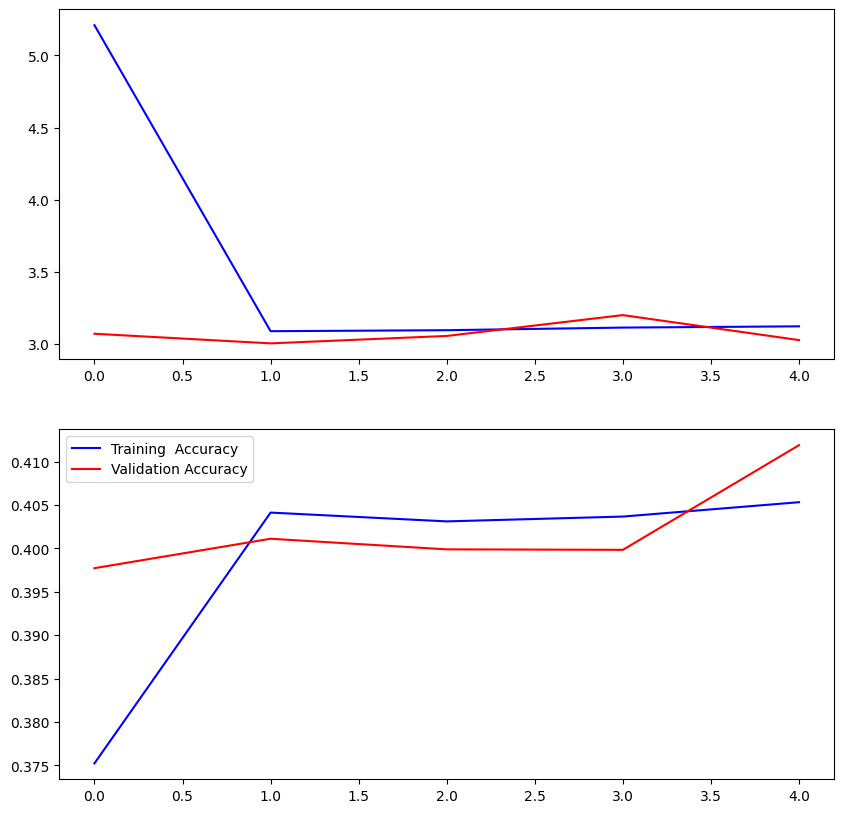

In [20]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['categorical_accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_categorical_accuracy'],color='r',label='Validation Accuracy')

plt.legend()  

In [21]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [22]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,
          validation_data=validation_ds,
          epochs=10,
          callbacks=[callback]
)

Epoch 1/10
4500/4500 [==============================] - 64s 14ms/step - loss: 1.2052 - categorical_accuracy: 0.5757 - val_loss: 1.0882 - val_categorical_accuracy: 0.6198
Epoch 2/10
4500/4500 [==============================] - 62s 14ms/step - loss: 0.9592 - categorical_accuracy: 0.6624 - val_loss: 0.9857 - val_categorical_accuracy: 0.6592
Epoch 3/10
4500/4500 [==============================] - 64s 14ms/step - loss: 0.8864 - categorical_accuracy: 0.6920 - val_loss: 1.0146 - val_categorical_accuracy: 0.6523
Epoch 4/10
4500/4500 [==============================] - 64s 14ms/step - loss: 0.8604 - categorical_accuracy: 0.7028 - val_loss: 0.9758 - val_categorical_accuracy: 0.6706
Epoch 5/10
4500/4500 [==============================] - 63s 14ms/step - loss: 0.8522 - categorical_accuracy: 0.7058 - val_loss: 1.0196 - val_categorical_accuracy: 0.6734
Epoch 6/10
4500/4500 [==============================] - 63s 14ms/step - loss: 0.8549 - categorical_accuracy: 0.7060 - val_loss: 1.0219 - val_categoric

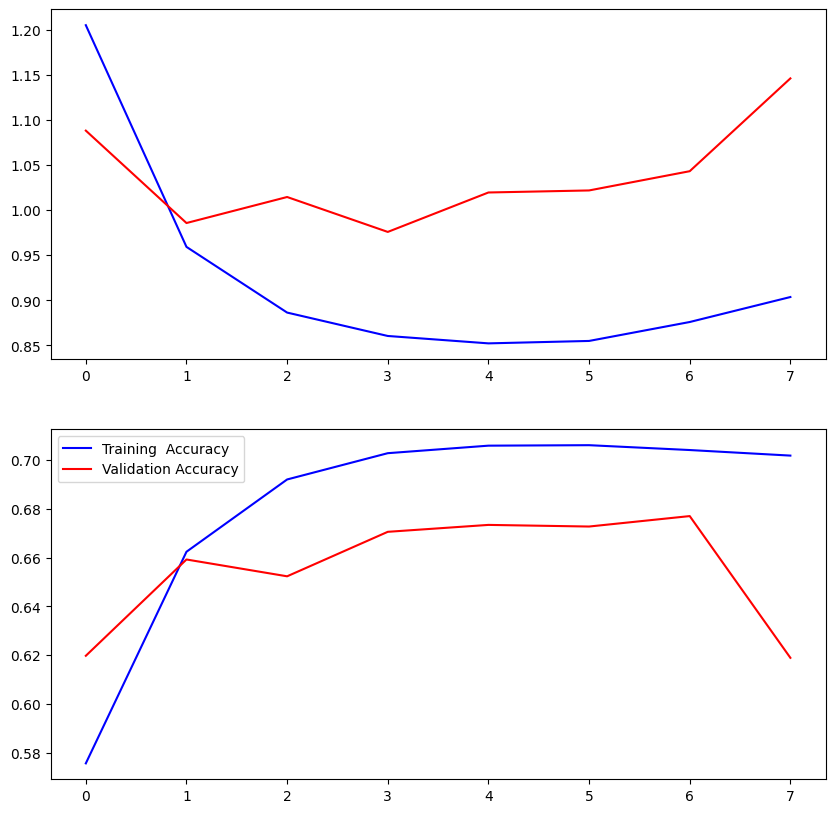

In [23]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['categorical_accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_categorical_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [24]:
model.evaluate(validation_ds)

1125/1125 [==============================] - 6s 6ms/step - loss: 1.1461 - categorical_accuracy: 0.6189


[1.1461471319198608, 0.6189444661140442]

# Komitet

In [76]:
class_number = len(class_names)
model_number = 3 # 3 classes, 3 classes, 4 classes
start_class = 0
end_class = 3
committee_models_1 = []
committee_models_2 = []
committee_models_3 = []

for i in range(model_number):
    # Determine and filter the subset of classes for this model
    subset_classes = class_names[start_class:end_class]
    
    subset_dataset_train = train_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))
    
    subset_dataset_val = validation_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))

    # Create, compile and train the models for the current subset of classes
    # Then add to the proper committee
    
    # Model1
    model1 = create_Architecture1()
    model1.compile(loss=loss_func,metrics=metrics)
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model1.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    
    committee_models_1.append(model1)
    
    # Model2
    model2 = create_Architecture2()
    model2.compile(loss=loss_func,metrics=metrics)
    history = model2.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_2.append(model2)
    
    # Model3
    model3 = create_Architecture3()
    model3.compile(loss=loss_func,metrics=metrics)
    history = model3.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_3.append(model3)
    
    # Update start/end index
    start_class = start_class+3
    end_class = start_class+3
    if end_class == class_number - 1:
        end_class = class_number

Epoch 1/20
5625/5625 [==============================] - 521s 92ms/step - loss: 1.5214 - categorical_accuracy: 0.4522 - auc: 0.8672 - precision: 0.6202 - recall: 0.2748 - val_loss: 1.3679 - val_categorical_accuracy: 0.5006 - val_auc: 0.8947 - val_precision: 0.6435 - val_recall: 0.3492
Epoch 2/20
5625/5625 [==============================] - 502s 89ms/step - loss: 1.2069 - categorical_accuracy: 0.5658 - auc: 0.9170 - precision: 0.7167 - recall: 0.4137 - val_loss: 1.2295 - val_categorical_accuracy: 0.5565 - val_auc: 0.9138 - val_precision: 0.7188 - val_recall: 0.3919
Epoch 3/20
5625/5625 [==============================] - 501s 89ms/step - loss: 1.1021 - categorical_accuracy: 0.6048 - auc: 0.9308 - precision: 0.7410 - recall: 0.4719 - val_loss: 1.1478 - val_categorical_accuracy: 0.5897 - val_auc: 0.9247 - val_precision: 0.7467 - val_recall: 0.4419
Epoch 4/20
5625/5625 [==============================] - 469s 83ms/step - loss: 1.0339 - categorical_accuracy: 0.6317 - auc: 0.9392 - precision: 0

Epoch 6/20
5625/5625 [==============================] - 684s 122ms/step - loss: 1.3180 - categorical_accuracy: 0.5186 - auc: 0.9008 - precision: 0.6926 - recall: 0.3417 - val_loss: 1.3329 - val_categorical_accuracy: 0.5082 - val_auc: 0.8987 - val_precision: 0.6906 - val_recall: 0.3235
Epoch 7/20
5625/5625 [==============================] - 674s 120ms/step - loss: 1.2977 - categorical_accuracy: 0.5266 - auc: 0.9040 - precision: 0.6985 - recall: 0.3528 - val_loss: 1.2946 - val_categorical_accuracy: 0.5315 - val_auc: 0.9041 - val_precision: 0.7132 - val_recall: 0.3482
Epoch 8/20
5625/5625 [==============================] - 745s 132ms/step - loss: 1.2787 - categorical_accuracy: 0.5329 - auc: 0.9069 - precision: 0.7016 - recall: 0.3632 - val_loss: 1.2898 - val_categorical_accuracy: 0.5298 - val_auc: 0.9053 - val_precision: 0.6946 - val_recall: 0.3641
Epoch 9/20
5625/5625 [==============================] - 733s 130ms/step - loss: 1.2580 - categorical_accuracy: 0.5428 - auc: 0.9099 - precisio

Epoch 13/20
5625/5625 [==============================] - 179s 32ms/step - loss: 0.9975 - categorical_accuracy: 0.6443 - auc: 0.9432 - precision: 0.7666 - recall: 0.5267 - val_loss: 1.1017 - val_categorical_accuracy: 0.6040 - val_auc: 0.9312 - val_precision: 0.7306 - val_recall: 0.4851
Epoch 14/20
5625/5625 [==============================] - 179s 32ms/step - loss: 0.9857 - categorical_accuracy: 0.6503 - auc: 0.9446 - precision: 0.7688 - recall: 0.5337 - val_loss: 1.0735 - val_categorical_accuracy: 0.6171 - val_auc: 0.9345 - val_precision: 0.7376 - val_recall: 0.5033
Epoch 15/20
5625/5625 [==============================] - 180s 32ms/step - loss: 0.9759 - categorical_accuracy: 0.6520 - auc: 0.9456 - precision: 0.7700 - recall: 0.5393 - val_loss: 1.0789 - val_categorical_accuracy: 0.6144 - val_auc: 0.9338 - val_precision: 0.7396 - val_recall: 0.4958
Epoch 16/20
5625/5625 [==============================] - 179s 32ms/step - loss: 0.9674 - categorical_accuracy: 0.6555 - auc: 0.9465 - precisio

Epoch 9/20
5625/5625 [==============================] - 404s 72ms/step - loss: 0.8462 - categorical_accuracy: 0.7006 - auc: 0.9587 - precision: 0.7938 - recall: 0.6132 - val_loss: 1.3426 - val_categorical_accuracy: 0.5471 - val_auc: 0.9035 - val_precision: 0.6518 - val_recall: 0.4530
Epoch 10/20
5625/5625 [==============================] - 401s 71ms/step - loss: 0.8235 - categorical_accuracy: 0.7077 - auc: 0.9608 - precision: 0.7970 - recall: 0.6233 - val_loss: 1.0973 - val_categorical_accuracy: 0.6166 - val_auc: 0.9332 - val_precision: 0.7170 - val_recall: 0.5314
Epoch 11/20
5625/5625 [==============================] - 432s 77ms/step - loss: 0.7994 - categorical_accuracy: 0.7175 - auc: 0.9630 - precision: 0.8036 - recall: 0.6381 - val_loss: 1.0344 - val_categorical_accuracy: 0.6460 - val_auc: 0.9403 - val_precision: 0.7337 - val_recall: 0.5728
Epoch 1/20
5625/5625 [==============================] - 173s 31ms/step - loss: 1.6894 - categorical_accuracy: 0.3860 - auc: 0.8292 - precision:

Epoch 8/20
5625/5625 [==============================] - 609s 108ms/step - loss: 1.2824 - categorical_accuracy: 0.5319 - auc: 0.9063 - precision: 0.7013 - recall: 0.3611 - val_loss: 1.3103 - val_categorical_accuracy: 0.5265 - val_auc: 0.9021 - val_precision: 0.6936 - val_recall: 0.3522
Epoch 9/20
5625/5625 [==============================] - 568s 101ms/step - loss: 1.2662 - categorical_accuracy: 0.5394 - auc: 0.9086 - precision: 0.7040 - recall: 0.3730 - val_loss: 1.2650 - val_categorical_accuracy: 0.5418 - val_auc: 0.9091 - val_precision: 0.6977 - val_recall: 0.3825
Epoch 10/20
5625/5625 [==============================] - 571s 101ms/step - loss: 1.2565 - categorical_accuracy: 0.5413 - auc: 0.9101 - precision: 0.7054 - recall: 0.3766 - val_loss: 1.2660 - val_categorical_accuracy: 0.5413 - val_auc: 0.9087 - val_precision: 0.7039 - val_recall: 0.3794
Epoch 11/20
5625/5625 [==============================] - 578s 103ms/step - loss: 1.2470 - categorical_accuracy: 0.5453 - auc: 0.9116 - precis

In [77]:
# Evaluating the committees

# Committee1
predictions = []
for model in committee_models_1:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_1 = np.mean(predictions, axis=0)  # Average predictions
predicted_labels_1 = np.argmax(combined_predictions_1, axis=1) # Mapping to labels

# Committee2
predictions = []
for model in committee_models_2:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_2 = np.mean(predictions, axis=0)  
predicted_labels_2 = np.argmax(combined_predictions_2, axis=1)

# Committee3
predictions = []
for model in committee_models_3:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_3 = np.mean(predictions, axis=0)  
predicted_labels_3 = np.argmax(combined_predictions_3, axis=1)


accuracy = np.mean(predicted_labels == tf_labels)

print("Accuracy:", accuracy)

5625/5625 [==============================] - 164s 29ms/step
Accuracy: 0.10033333333333333


In [78]:
accuracy_1 = accuracy_score(tf_labels, predicted_labels_1)
precision_1 = precision_score(tf_labels, predicted_labels_1, average='weighted')
recall_1 = recall_score(tf_labels, predicted_labels_1, average='weighted')
f1_1 = f1_score(tf_labels, predicted_labels_1, average='weighted')

print("Accuracy:", accuracy_1)
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_1)

accuracy_2 = accuracy_score(tf_labels, predicted_labels_2)
precision_2 = precision_score(tf_labels, predicted_labels_2, average='weighted')
recall_2 = recall_score(tf_labels, predicted_labels_2, average='weighted')
f1_2 = f1_score(tf_labels, predicted_labels_2, average='weighted')

print("Accuracy:", accuracy_2)
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F1 Score:", f1_2)

accuracy_3 = accuracy_score(tf_labels, predicted_labels_3)
precision_3 = precision_score(tf_labels, predicted_labels_3, average='weighted')
recall_3 = recall_score(tf_labels, predicted_labels_3, average='weighted')
f1_3 = f1_score(tf_labels, predicted_labels_3, average='weighted')

print("Accuracy:", accuracy_3)
print("Precision:", precision_3)
print("Recall:", recall_3)
print("F1 Score:", f1_3)

Accuracy: 0.1034111111111111
Precision: 0.10323954581932705
Recall: 0.1034111111111111
F1 Score: 0.10204983600798848
Accuracy: 0.10357777777777778
Precision: 0.1034294022258029
Recall: 0.10357777777777778
F1 Score: 0.10051241041749749
Accuracy: 0.1022
Precision: 0.10200570512059544
Recall: 0.1022
F1 Score: 0.09838562170278978


In [ ]:
class_number = len(class_names) # na noc
model_number = 3 # 3 classes, 3 classes, 4 classes
start_class = 0
end_class = 3
committee_models_1 = []
committee_models_2 = []
committee_models_3 = []

for i in range(model_number):
    # Determine and filter the subset of classes for this model
    subset_classes = class_names[start_class:end_class]
    
    subset_dataset_train = train_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))
    
    subset_dataset_val = validation_ds.filter(lambda x, y: tf.reduce_any([tf.equal(y, 
                    tf.one_hot(class_names.index(class_name), depth=len(class_names))) for class_name in subset_classes]))

    # Create, compile and train the models for the current subset of classes
    # Then add to the proper committee
    
    # Model1
    model1 = create_Architecture1()
    model1.compile(loss=loss_func,metrics=metrics)
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model1.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    
    committee_models_1.append(model1)
    
    # Model2
    model2 = create_Architecture2()
    model2.compile(loss=loss_func,metrics=metrics)
    history = model2.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_2.append(model2)
    
    # Model3
    model3 = create_Architecture3()
    model3.compile(loss=loss_func,metrics=metrics)
    history = model3.fit(
        subset_dataset_train,
        validation_data=subset_dataset_val, 
        epochs=20, 
        callbacks = [callback]
    )
    committee_models_3.append(model3)
    
    # Update start/end index
    start_class = start_class+3
    end_class = start_class+3
    if end_class == class_number - 1:
        end_class = class_number

Epoch 1/20
5625/5625 [==============================] - 407s 72ms/step - loss: 1.5288 - categorical_accuracy: 0.4503 - auc: 0.8658 - precision: 0.6193 - recall: 0.2721 - val_loss: 1.3403 - val_categorical_accuracy: 0.5147 - val_auc: 0.8973 - val_precision: 0.7130 - val_recall: 0.3038
Epoch 2/20
5625/5625 [==============================] - 402s 72ms/step - loss: 1.2184 - categorical_accuracy: 0.5612 - auc: 0.9155 - precision: 0.7158 - recall: 0.4091 - val_loss: 1.5101 - val_categorical_accuracy: 0.4591 - val_auc: 0.8716 - val_precision: 0.6091 - val_recall: 0.3120
Epoch 3/20
5625/5625 [==============================] - 406s 72ms/step - loss: 1.1114 - categorical_accuracy: 0.6035 - auc: 0.9296 - precision: 0.7416 - recall: 0.4685 - val_loss: 1.1373 - val_categorical_accuracy: 0.5932 - val_auc: 0.9263 - val_precision: 0.7401 - val_recall: 0.4538
Epoch 4/20
5625/5625 [==============================] - 407s 72ms/step - loss: 1.0395 - categorical_accuracy: 0.6294 - auc: 0.9384 - precision: 0

Epoch 10/20
5625/5625 [==============================] - 572s 102ms/step - loss: 1.2536 - categorical_accuracy: 0.5445 - auc: 0.9106 - precision: 0.7047 - recall: 0.3814 - val_loss: 1.2629 - val_categorical_accuracy: 0.5409 - val_auc: 0.9094 - val_precision: 0.6994 - val_recall: 0.3850
Epoch 11/20
5625/5625 [==============================] - 569s 101ms/step - loss: 1.2411 - categorical_accuracy: 0.5488 - auc: 0.9125 - precision: 0.7088 - recall: 0.3898 - val_loss: 1.2461 - val_categorical_accuracy: 0.5511 - val_auc: 0.9119 - val_precision: 0.6986 - val_recall: 0.4021
Epoch 12/20
2194/5625 [==========>...................] - ETA: 4:35 - loss: 1.2422 - categorical_accuracy: 0.5508 - auc: 0.9121 - precision: 0.7137 - recall: 0.3901

In [ ]:
# Evaluating the committees

# Committee1
predictions = []
for model in committee_models_1:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_1 = np.mean(predictions, axis=0)  # Average predictions
predicted_labels_1 = np.argmax(combined_predictions_1, axis=1) # Mapping to labels

# Committee2
predictions = []
for model in committee_models_2:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_2 = np.mean(predictions, axis=0)  
predicted_labels_2 = np.argmax(combined_predictions_2, axis=1)

# Committee3
predictions = []
for model in committee_models_3:
    model_predictions = model.predict(test_ds)
    predictions.append(model_predictions)
    
combined_predictions_3 = np.mean(predictions, axis=0)  
predicted_labels_3 = np.argmax(combined_predictions_3, axis=1)


accuracy = np.mean(predicted_labels == tf_labels)

print("Accuracy:", accuracy)

In [ ]:
accuracy_1 = accuracy_score(tf_labels, predicted_labels_1)
precision_1 = precision_score(tf_labels, predicted_labels_1, average='weighted')
recall_1 = recall_score(tf_labels, predicted_labels_1, average='weighted')
f1_1 = f1_score(tf_labels, predicted_labels_1, average='weighted')

print("Accuracy:", accuracy_1)
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_1)

accuracy_2 = accuracy_score(tf_labels, predicted_labels_2)
precision_2 = precision_score(tf_labels, predicted_labels_2, average='weighted')
recall_2 = recall_score(tf_labels, predicted_labels_2, average='weighted')
f1_2 = f1_score(tf_labels, predicted_labels_2, average='weighted')

print("Accuracy:", accuracy_2)
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F1 Score:", f1_2)

accuracy_3 = accuracy_score(tf_labels, predicted_labels_3)
precision_3 = precision_score(tf_labels, predicted_labels_3, average='weighted')
recall_3 = recall_score(tf_labels, predicted_labels_3, average='weighted')
f1_3 = f1_score(tf_labels, predicted_labels_3, average='weighted')

print("Accuracy:", accuracy_3)
print("Precision:", precision_3)
print("Recall:", recall_3)
print("F1 Score:", f1_3)